## Replication of paper: 
### "Dimensionality Reduction in Sentence Transformer Vector Databases with Fast Fourier Transform (April 10, 2024)"
### Link: https://arxiv.org/pdf/2404.06278

/home/user/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


*******************Report Execution Time ************** :
Embedding Generation Time: 0.4904 seconds
FFT Reduction Time: 0.0006 seconds
PCA Reduction Time: 0.0011 seconds
FAISS Index Creation Time: 0.0001 seconds
FFT Search Time: 0.0001 seconds
PCA Search Time: 0.0001 seconds
*******************Report Dimensions ************** :
Orginal Embedding: (10, 768)
reduced_embeddings_fft:  (10, 153)
reduced_embeddings_pca:  (10, 10)


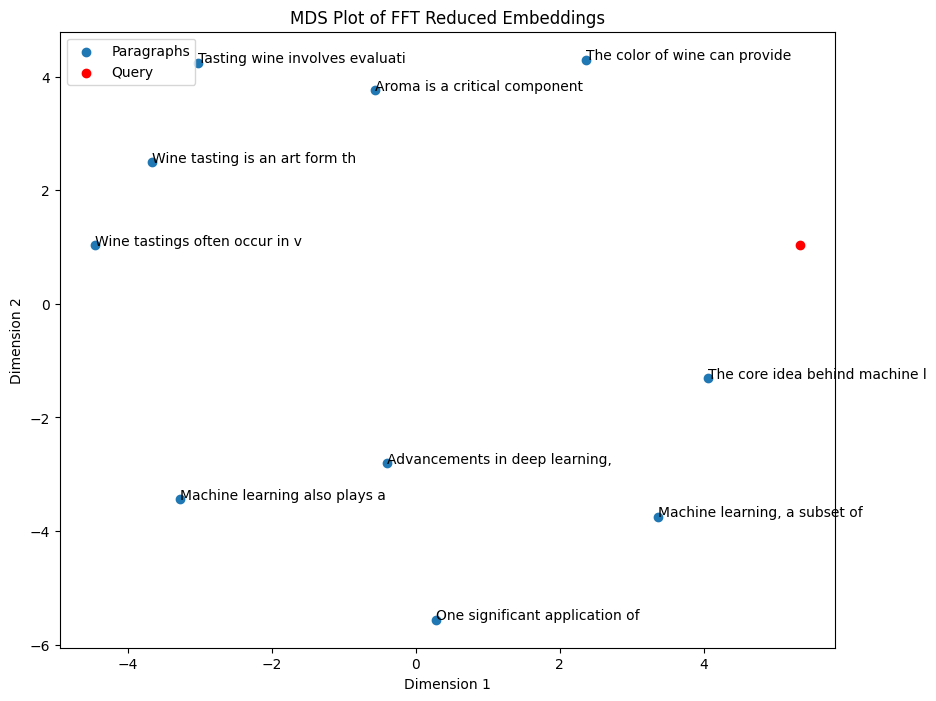

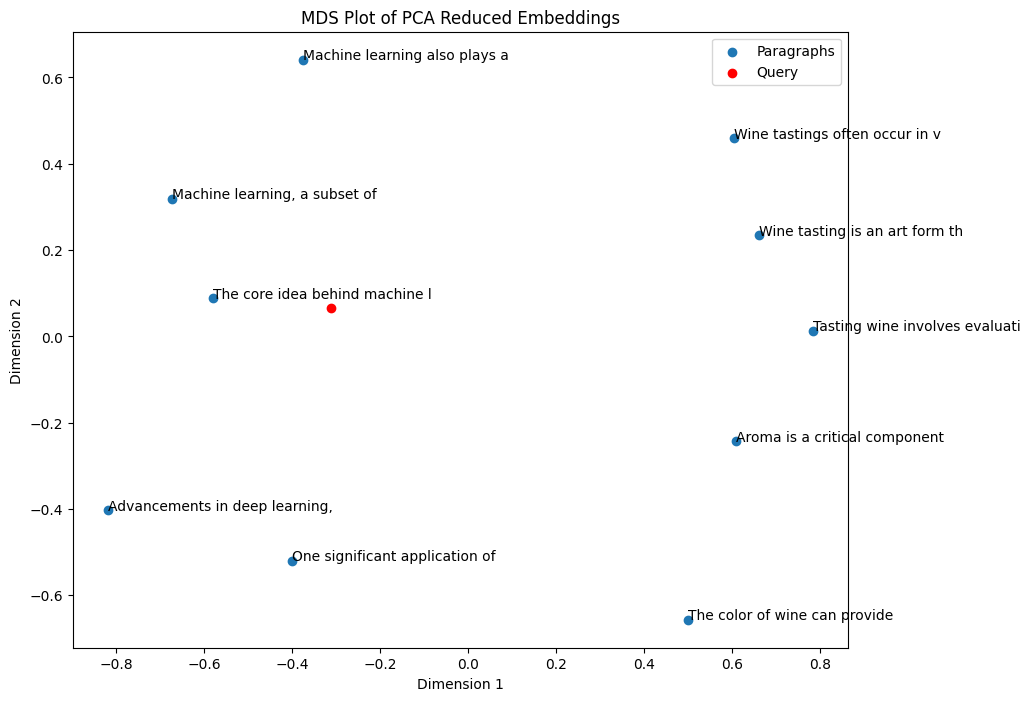

FFT Reduced Index Search Results: ['The core idea behind machine learning is the development of algorithms that can process large sets of data, identify patterns, and make predictions. Techniques like neural networks, decision trees, and support vector machines are commonly employed in various applications.', 'Machine learning, a subset of artificial intelligence, focuses on building systems that learn from data to make predictions or decisions without being explicitly programmed for specific tasks. It’s revolutionizing industries by enabling smarter, more efficient operations.', 'Machine learning also plays a crucial role in computer vision, allowing computers to interpret and make decisions based on visual data. This capability is fundamental for facial recognition systems, autonomous vehicles, and medical imaging analysis.', 'One significant application of machine learning is in natural language processing (NLP), where machines understand, interpret, and generate human language. Thi

In [15]:

import numpy as np
from scipy.fft import fft
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import faiss
import time
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist

# Load Sentence Transformer model
# page 6: "We evaluated quite a few “sentence similarity” models and found that “all-mpnet-base-v2”one works best for our
#purposes. Its sequence size is 384 and embeddings dimension is 768" 

model_name = 'sentence-transformers/all-mpnet-base-v2'
model = SentenceTransformer(model_name)

# Example sentences 
# page 7
sentences = [
    "Machine learning, a subset of artificial intelligence, focuses on building systems that learn from data to make predictions or decisions without being explicitly programmed for specific tasks. It’s revolutionizing industries by enabling smarter, more efficient operations.",
    "The core idea behind machine learning is the development of algorithms that can process large sets of data, identify patterns, and make predictions. Techniques like neural networks, decision trees, and support vector machines are commonly employed in various applications.",
    "One significant application of machine learning is in natural language processing (NLP), where machines understand, interpret, and generate human language. This technology powers virtual assistants, chatbots, and translation services, enhancing communication across languages.",
    "Machine learning also plays a crucial role in computer vision, allowing computers to interpret and make decisions based on visual data. This capability is fundamental for facial recognition systems, autonomous vehicles, and medical imaging analysis.",
    "Advancements in deep learning, a subset of machine learning, are driving breakthroughs in areas like generative models and reinforcement learning. These innovations pave the way for more sophisticated AI applications, shaping the future of technology.",
    "Wine tasting is an art form that involves the sensory evaluation of wine, focusing on its color, aroma, and flavor profile. Enthusiasts and professionals alike engage in this practice to appreciate wine’s complexity.",
    "The color of wine can provide insights into its age, grape variety, and production methods. Observers evaluate wine by tilting the glass against a white background to examine its hue and clarity.",
    "Aroma is a critical component of wine tasting, revealing information about the wine’s grape variety, terroir, and aging process. Tasters often swirl the wine to release its bouquet before inhaling deeply to identify specific scents.",
    "Tasting wine involves evaluating its palate, noting the balance between sweetness, acidity, tannins, and alcohol. This stage assesses the wine’s flavor profile, structure, and finish, contributing to its overall quality assessment.",
    "Wine tastings often occur in vineyards, wine bars, and festivals, serving as educational experiences and social gatherings. Participants learn to distinguish between different wine varieties and regions, enhancing their appreciation for this sophisticated beverage."
]

print("*******************Report Execution Time ************** :")

# Encode sentences to get embeddings
start_time = time.time()
embeddings = model.encode(sentences)
embedding_time = time.time() - start_time
print(f"Embedding Generation Time: {embedding_time:.4f} seconds")


# Apply FFT and retain low-frequency components
def reduce_dimensions_fft(embeddings, factor):
    reduced_embeddings = []
    for vec in embeddings:
        fft_result = fft(vec)
        amplitudes = np.abs(fft_result)
        reduced = amplitudes[:len(amplitudes)//factor]
        reduced_embeddings.append(reduced)
    return np.array(reduced_embeddings)
    

# Apply PCA for dimensionality reduction
def reduce_dimensions_pca(embeddings, n_components):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings, pca

# Define constants for dimensionality reduction
reduction_factor = 5

# Reduce dimensions using FFT
start_time = time.time()
reduced_embeddings_fft = reduce_dimensions_fft(embeddings, reduction_factor)
fft_time = time.time() - start_time
print(f"FFT Reduction Time: {fft_time:.4f} seconds")

# Reduce dimensions using PCA
n_components_pca = min(embeddings.shape[0], embeddings.shape[1] // reduction_factor)
start_time = time.time()
reduced_embeddings_pca, pca_model = reduce_dimensions_pca(embeddings, n_components_pca)
pca_time = time.time() - start_time
print(f"PCA Reduction Time: {pca_time:.4f} seconds")

#"All documents converted to embeddings vectors by the sentence transformer model are stored in Facebook FAISS vector database [10].
#We retrieve most relevant (semantically close) to a query documents represented by vectors from this database index."
# page 6

# Store embeddings in FAISS index
def create_faiss_index(embeddings):
    d = embeddings.shape[1]
    index = faiss.IndexFlatL2(d)  # L2 distance index
    index.add(embeddings)
    return index

# Create FAISS indexes
start_time = time.time()
index_fft = create_faiss_index(reduced_embeddings_fft)
index_pca = create_faiss_index(reduced_embeddings_pca)
faiss_index_time = time.time() - start_time
print(f"FAISS Index Creation Time: {faiss_index_time:.4f} seconds")

# Query example
query = model.encode(["Training data in Machine Learning"])[0]

# Query reduction for FFT and PCA
query_reduced_fft = reduce_dimensions_fft([query], reduction_factor)[0]
query_reduced_pca = pca_model.transform([query])[0]


# Search in FAISS index
def search_index(index, query_embedding, k=4):
    D, I = index.search(np.array([query_embedding]), k)
    return [sentences[i] for i in I[0]]

# Search in FAISS index for FFT
start_time = time.time()
retrieved_sentences_fft = search_index(index_fft, query_reduced_fft)
fft_search_time = time.time() - start_time
print(f"FFT Search Time: {fft_search_time:.4f} seconds")

# Search in FAISS index for PCA
start_time = time.time()
retrieved_sentences_pca = search_index(index_pca, query_reduced_pca)
pca_search_time = time.time() - start_time
print(f"PCA Search Time: {pca_search_time:.4f} seconds")

print("*******************Report Dimensions ************** :")
print("Orginal Embedding:", embeddings.shape)
print("reduced_embeddings_fft: ", reduced_embeddings_fft.shape)
print("reduced_embeddings_pca: ", reduced_embeddings_pca.shape)

# Calculate pairwise distances for MDS
all_embeddings_fft = np.vstack([query_reduced_fft, reduced_embeddings_fft])
all_embeddings_pca = np.vstack([query_reduced_pca, reduced_embeddings_pca])

distances_fft = cdist(all_embeddings_fft, all_embeddings_fft, 'euclidean')
distances_pca = cdist(all_embeddings_pca, all_embeddings_pca, 'euclidean')

# Visualize using MDS
def plot_mds(distances, title):
    mds = MDS(n_components=2, dissimilarity="precomputed")
    mds_results = mds.fit_transform(distances)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(mds_results[1:, 0], mds_results[1:, 1], label='Paragraphs')
    plt.scatter(mds_results[0, 0], mds_results[0, 1], color='red', label='Query')
    for i, txt in enumerate(sentences):
        plt.annotate(txt[:30], (mds_results[i+1, 0], mds_results[i+1, 1]))
    plt.legend()
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

plot_mds(distances_fft, "MDS Plot of FFT Reduced Embeddings")
plot_mds(distances_pca, "MDS Plot of PCA Reduced Embeddings")

# Print search results
print("FFT Reduced Index Search Results:", retrieved_sentences_fft)
print("PCA Reduced Index Search Results:", retrieved_sentences_pca)